<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.0.4"><span class="toc-item-num">3.0.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.0.4"><span class="toc-item-num">4.0.4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Выбор-Модели" data-toc-modified-id="Выбор-Модели-4.0.5"><span class="toc-item-num">4.0.5&nbsp;&nbsp;</span>Выбор Модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.0.6"><span class="toc-item-num">4.0.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 


from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
SEED=666

Загрузим данные

In [3]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

Проверим хронологию дат

In [4]:
display(df.index.is_monotonic)

True

Посмотрим на общую информацию о датафрейме и данных

In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Посмотрим на сами данные

In [7]:
display(df.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


В соответствии с задачей нужно сделать ресемплинг по одному часу

In [8]:
df = df.resample('1D').sum() 

In [9]:
display(df.head(10))

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
2018-03-06,1109
2018-03-07,1441
2018-03-08,1659
2018-03-09,1076


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2018-03-01 to 2018-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  184 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


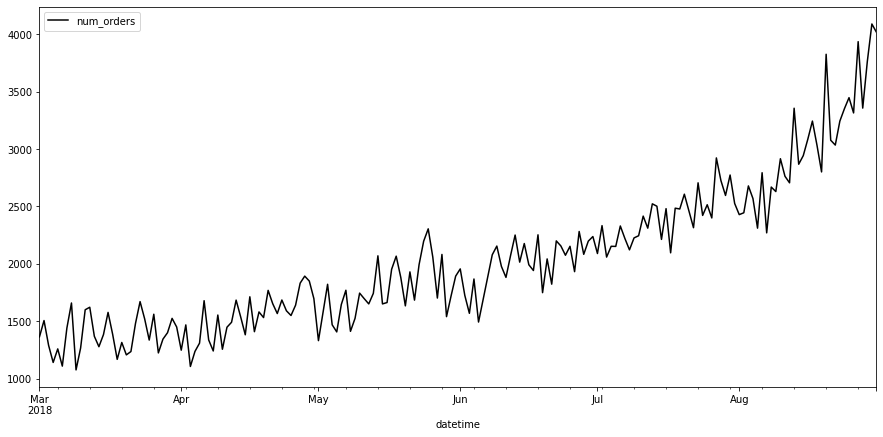

In [10]:
df.plot(figsize=(15,7), color='black');

## Анализ

Рассмотрим сезонность

In [12]:
decomposed_data = seasonal_decompose(df)

Тренд

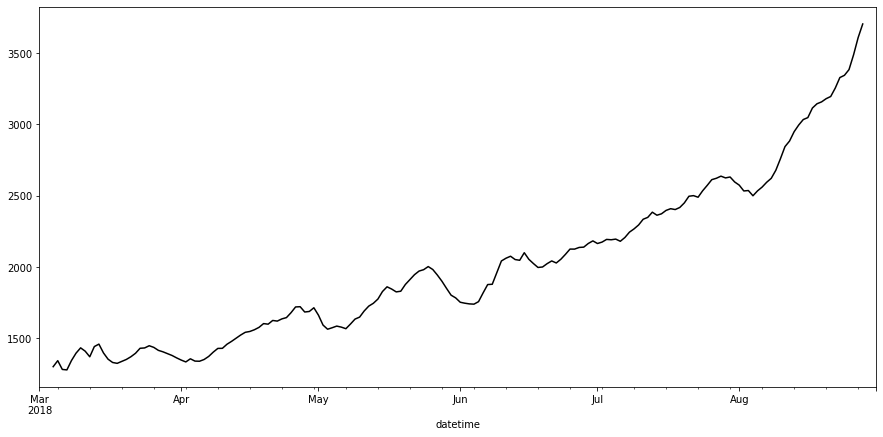

In [13]:
decomposed_data.trend.plot(figsize=(15,7), color='black');

Сезонность

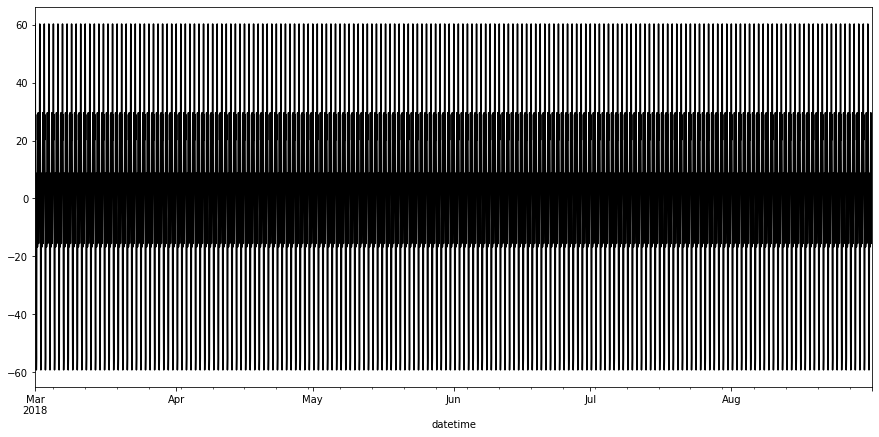

In [55]:
decomposed_data.seasonal.plot(figsize=(15,7), color='black');

Остаток

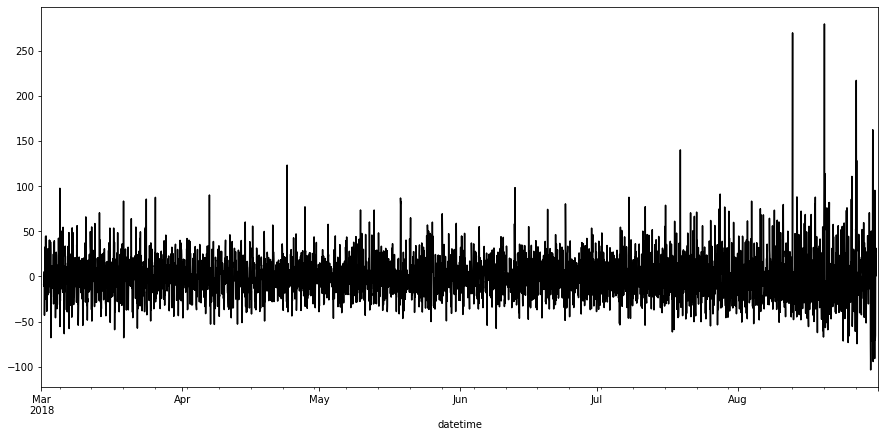

In [56]:
decomposed_data.resid.plot(figsize=(15,7), color='black');

нужно сделать ресемплинг и посмотреть в другом временном интервале т.к. очень много шума и определить сезонность относительно тяжело

In [57]:
decomposed_data_2 = seasonal_decompose(df['2018-08-01':'2018-08-07'])

Тренд

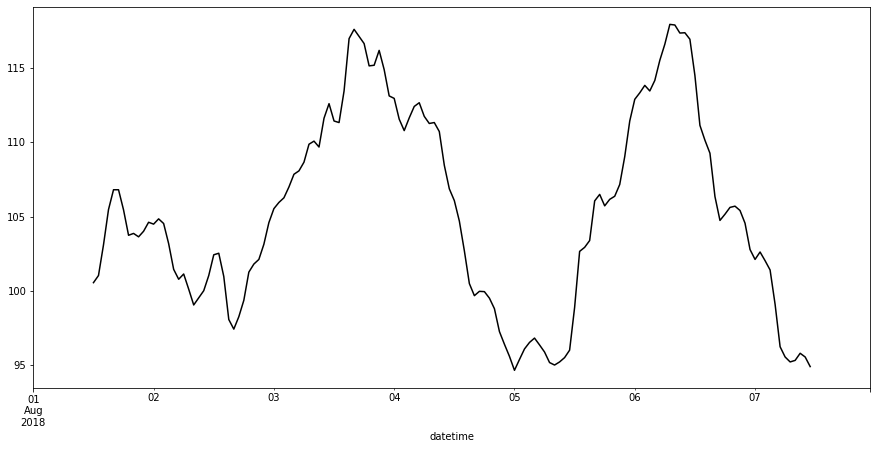

In [58]:
decomposed_data_2.trend.plot(figsize=(15,7), color='black', ax=plt.gca());

Сезонность

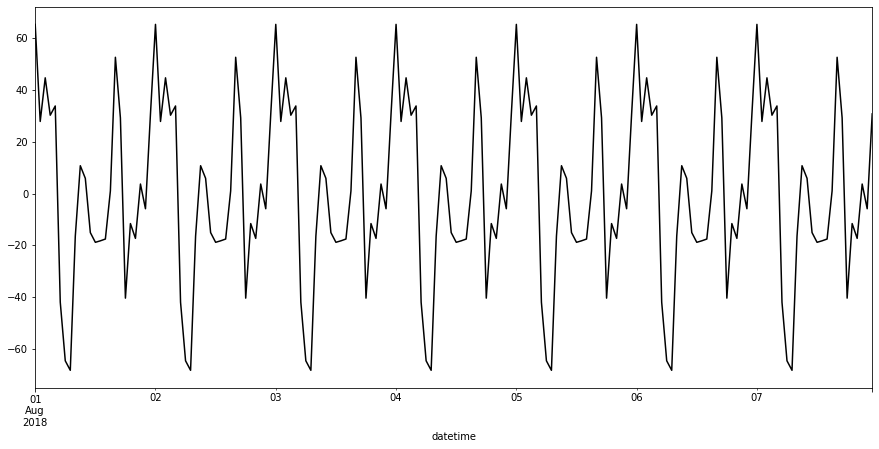

In [59]:
decomposed_data_2.seasonal.plot(figsize=(15,7), color='black', ax=plt.gca());

Остаток

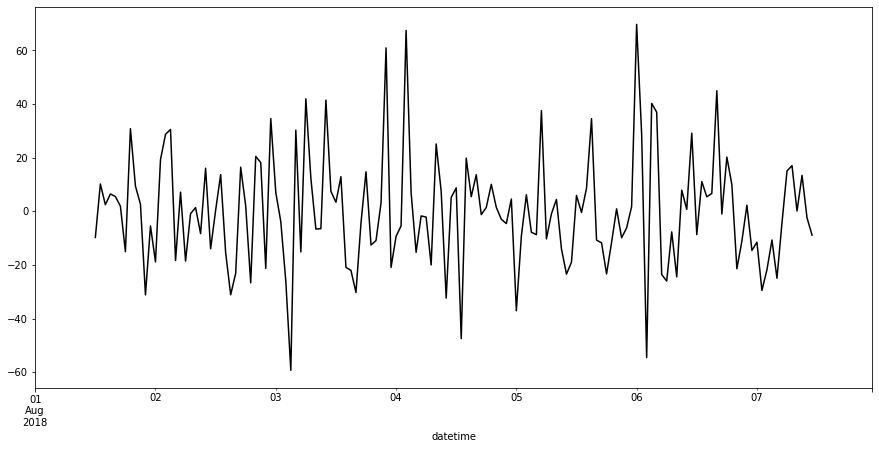

In [60]:
decomposed_data_2.resid.plot(figsize=(15,7), color='black', ax=plt.gca());

стационарные временные ряды

In [61]:
df_plot = df.copy()
df_plot['rolling_mean'] = df_plot.rolling(24).mean()
df_plot['std'] = df_plot['num_orders'].rolling(24).std()

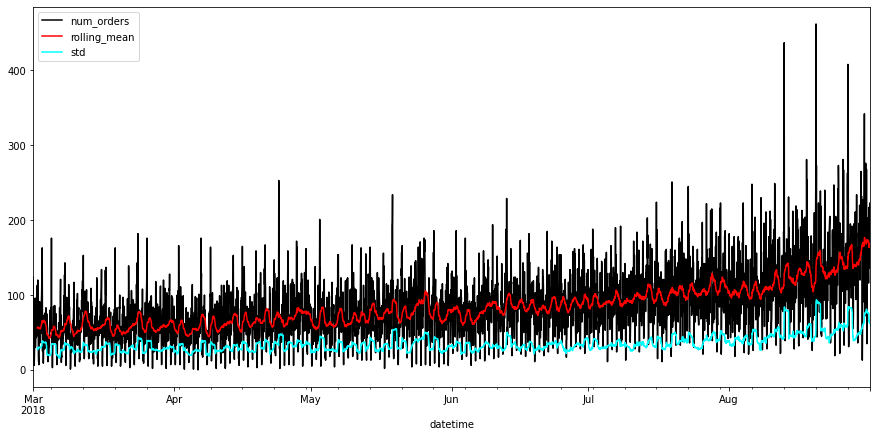

In [62]:
df_plot.plot(figsize=(15,7), color=['black', 'red', 'cyan']);

In [63]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()

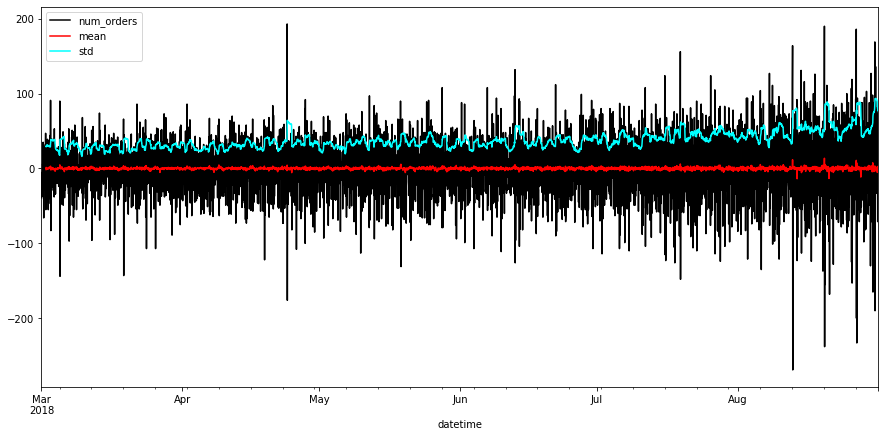

In [64]:
df_shift.plot(figsize=(15,7), color=['black', 'red', 'cyan']);

Вывод:
<br>
используя метод декомпозиции, мы определили следующие ключевые моменты:
<br>
<br>
В течение исследуемого периода времени отмечается общая тенденция к увеличению количества заказов такси, вероятно вызванная расширением таксомоторной компании. Однако, существует предположение, что сфера услуг такси не подвержена месячным сезонным колебаниям. Для подтверждения или опровержения данной гипотезы потребуются данные за более длительный период времени.
<br>
<br>
Графики наглядно демонстрируют суточную сезонную динамику. Количество заказов минимально в ночное время, в то время как пик вечернего часа пик – это момент максимального спроса на услуги такси.

## Обучение

Пропишем функцию для создания признаков, а именно день недели, час -"отстающие значения", скользящее среднее:

In [65]:
def make_features(data, max_lag, rolling_mean_size):
    data_2 = data.copy()
    
    data_2['month'] = data.index.month
    data_2['day'] = data.index.day
    data_2['dayofweek'] = data.index.dayofweek
    data_2['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data_2['lag_{}'.format(lag)] = data_2['num_orders'].shift(lag)

    data_2['rolling_mean'] = data_2['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_2 = data_2.dropna()
    
    return data_2

Применим функцию с лагом до 24 часов и 100-м скользящим средним:

In [66]:
data_2 = make_features(df, 24, 100)

Удалим пропски и посмотрим данные:

In [67]:
data_2 = data_2.dropna()

In [68]:
data_2

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,3,5,0,4,51.0,32.0,176.0,86.0,68.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,3,5,0,5,34.0,51.0,32.0,176.0,86.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,3,5,0,6,16.0,34.0,51.0,32.0,176.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,3,5,0,7,3.0,16.0,34.0,51.0,32.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,3,5,0,8,14.0,3.0,16.0,34.0,51.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,157.33
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,156.74
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,156.63


Поделим данные на фичи и таргеты:

In [69]:
train, test = train_test_split(data_2, shuffle=False, test_size=0.1)

In [70]:
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

In [71]:
target_train = train['num_orders']
target_test = test['num_orders']

In [72]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 29)
(432, 29)
(3884,)
(432,)


In [73]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

In [74]:
def RMSE(target, predict):
    return np.sqrt(mean_squared_error(target, predict))

In [75]:
RMSE_score = make_scorer(RMSE, greater_is_better=False)

#### CatBoost

In [76]:
CatB = CatBoostRegressor(random_state = SEED)

In [77]:
parameters = [{'depth' : [3],
                'learning_rate' : [0.1],
                'iterations' : [300],
                'verbose' : [False]
               }]

In [78]:
clf = GridSearchCV(CatB, parameters, cv=my_cv, scoring='neg_mean_squared_error')

In [79]:
clf.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fbeb89f1820>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fbeb895c820>,
             param_grid=[{'depth': [3], 'iterations': [300],
                          'learning_rate': [0.1], 'verbose': [False]}],
             scoring='neg_mean_squared_error')

In [80]:
print((clf.best_score_*-1)**0.5)

26.699153832744493


In [81]:
best_CatB = clf.best_params_

In [82]:
print(best_CatB)

{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}


#### Linear Regression

In [83]:
l_r = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [84]:
l_r.fit(features_train, target_train)

LinearRegression(normalize=True)

In [85]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

In [86]:
l_r_cv_score = pd.Series(cross_val_score(l_r,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)

In [87]:
print(l_r_cv_score)

28.20064200976903


#### LGBMRegressor

In [88]:
LGBMR = LGBMRegressor()

In [89]:
parameters = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[SEED]}]

In [90]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

In [91]:
clf = GridSearchCV(LGBMR, parameters, cv=my_cv, scoring='neg_mean_squared_error')

In [92]:
clf.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fbeb855d200>,
             estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'random_state': [666]}],
             scoring='neg_mean_squared_error')

In [93]:
print(clf.best_params_)
print((clf.best_score_*-1)**0.5)

{'learning_rate': 0.1, 'random_state': 666}
27.108694691294517


#### XGBoost

In [94]:
modelXGB = XGBRegressor(random_state = SEED)

In [95]:
param_search = {
    'max_depth': [3, 4, 5],  # Разные значения max_depth
    'min_samples_leaf': [1, 2, 3],  # Разные значения min_samples_leaf
    'learning_rate': [0.1, 0.01, 0.001],  # Разные значения learning_rate
    'n_estimators': [500]
}

In [96]:
tscv = TimeSeriesSplit(n_splits=5)

In [97]:
gsearchXGB = GridSearchCV(estimator=modelXGB, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')

In [98]:
gsearchXGB.fit(features_train, target_train)

[08:19:24] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:19:35] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:19:47] WARNING: ../src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actual

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=666, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subs

In [99]:
gsearchXGB.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 500}

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [100]:
np.abs(gsearchXGB.best_score_)

25.430543453785468

## Тестирование

#### CatBoost

In [101]:
modelCat = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)

In [102]:
modelCat.fit(features_train, target_train)

In [103]:
modelCat_predict = modelCat.predict(features_test)

In [104]:
rmse_cbr = mean_squared_error(target_test, modelCat_predict) ** 0.5

In [105]:
print(rmse_cbr)

42.67401062206723


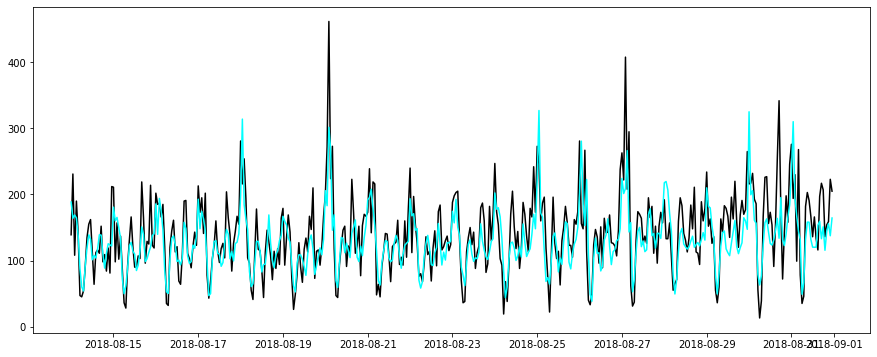

In [106]:
plt.figure(figsize=(15, 6))
plt.plot(target_test.index, target_test, 'black', target_test.index, modelCat_predict,'cyan');

#### Linear Regression

In [107]:
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [108]:
regression_model.fit(features_train, target_train)

LinearRegression(normalize=True)

In [109]:
regression_model_predictions = regression_model.predict(features_test)

In [110]:
regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)

In [111]:
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 47.083


In [112]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(15,7), color=['black', 'cyan'])
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(15,7), color=['black', 'cyan'])

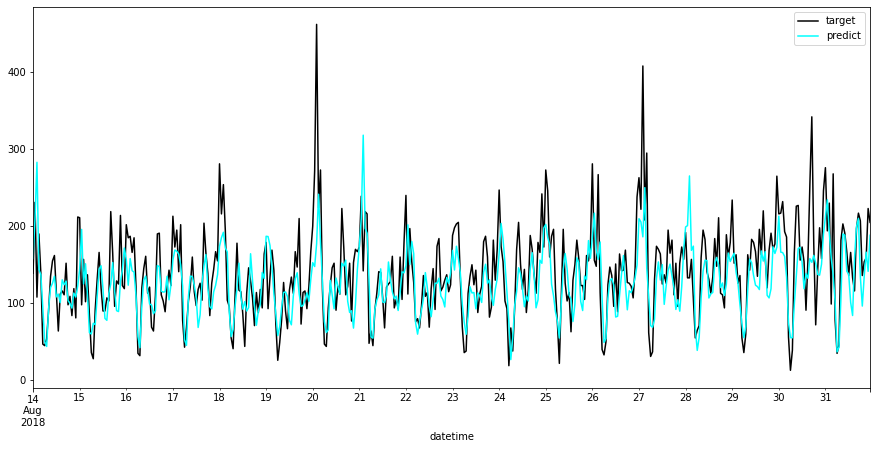

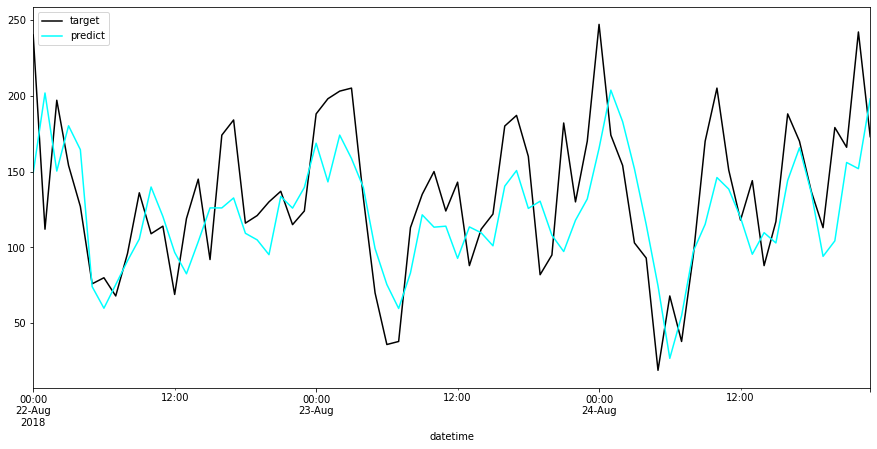

In [113]:
graphicaizer(regression_model_predictions)

#### LGBMRegressor

In [114]:
model_XGB = XGBRegressor(depth = 3, learning_rate = 0.03, random_state = SEED)

In [115]:
LGBMR.fit(features_train, target_train)

LGBMRegressor()

In [116]:
target_predict = LGBMR.predict(features_test)

In [117]:
rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [118]:
print(rmse_LGBMR)

40.24659040147057


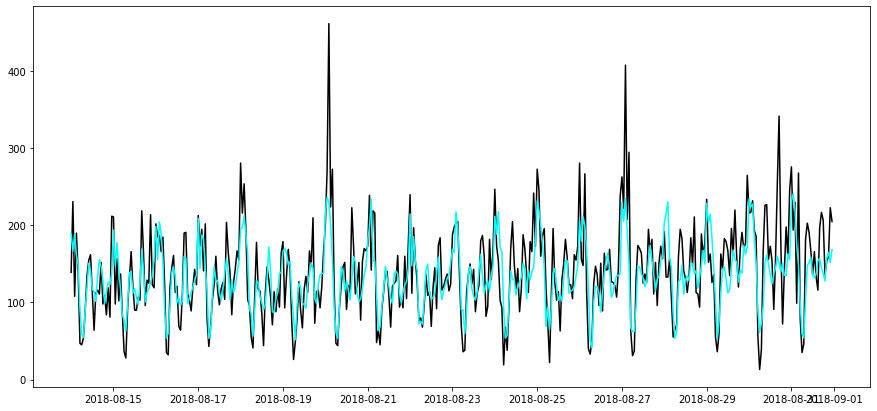

In [119]:
plt.figure(figsize=(15, 7))
plt.plot(target_test.index, target_test, 'black', target_test.index, target_predict,'cyan');

#### XGBoost

In [120]:
modelXGB = XGBRegressor(max_depth = 3, n_estimators = 500, learning_rate = 0.03,random_state = SEED)

In [121]:
modelXGB.fit(features_train, target_train, eval_set = [(features_train, target_train),(features_test, target_test)], eval_metric = 'rmse', verbose = 10);

[0]	validation_0-rmse:85.15301	validation_1-rmse:148.43062
[10]	validation_0-rmse:65.46347	validation_1-rmse:122.02686
[20]	validation_0-rmse:51.49486	validation_1-rmse:103.12272
[30]	validation_0-rmse:41.76069	validation_1-rmse:88.74713
[40]	validation_0-rmse:35.16929	validation_1-rmse:77.99380
[50]	validation_0-rmse:30.70224	validation_1-rmse:70.51569
[60]	validation_0-rmse:27.80460	validation_1-rmse:64.93559
[70]	validation_0-rmse:25.94278	validation_1-rmse:60.59833
[80]	validation_0-rmse:24.75479	validation_1-rmse:57.22778
[90]	validation_0-rmse:23.94902	validation_1-rmse:54.82422
[100]	validation_0-rmse:23.30731	validation_1-rmse:52.55739
[110]	validation_0-rmse:22.83279	validation_1-rmse:50.71600
[120]	validation_0-rmse:22.53430	validation_1-rmse:49.55625
[130]	validation_0-rmse:22.23532	validation_1-rmse:48.55342
[140]	validation_0-rmse:21.99353	validation_1-rmse:47.94376
[150]	validation_0-rmse:21.81836	validation_1-rmse:47.56905
[160]	validation_0-rmse:21.63858	validation_1-rm

In [122]:
rmse_XGB = mean_squared_error(target_test, modelXGB.predict(features_test))**0.5

In [123]:
print(rmse_XGB)

43.45435097264555


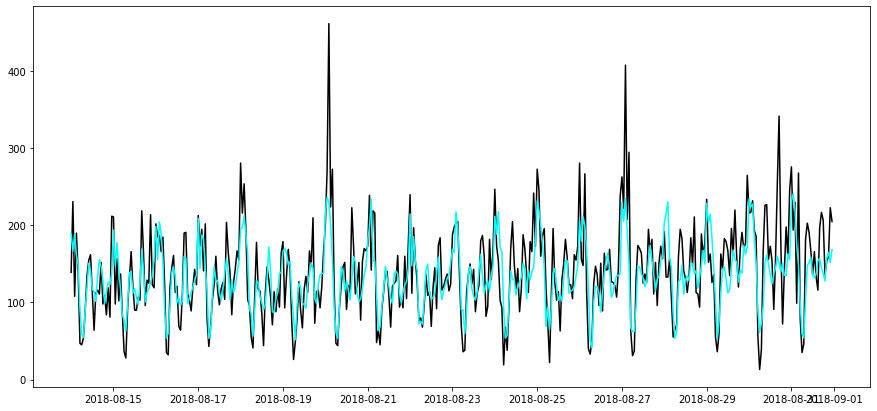

In [124]:
plt.figure(figsize=(15, 7))
plt.plot(target_test.index, target_test, 'black', target_test.index, target_predict,'cyan');

#### Выбор Модели

In [125]:
predictive_model_scores = pd.DataFrame(data=[('CatBoost',rmse_cbr), 
                                             ('Linear Regression', regression_RMSE),
                                            ('LGBMRegressor',rmse_LGBMR),
                                             ('XGBoost',rmse_XGB)],
                                       columns=['model', 'testing_rmse'])

In [126]:
predictive_model_scores

,model,testing_rmse
0,CatBoost,42.674011
1,Linear Regression,47.083000
2,LGBMRegressor,40.246590
3,XGBoost,43.454351


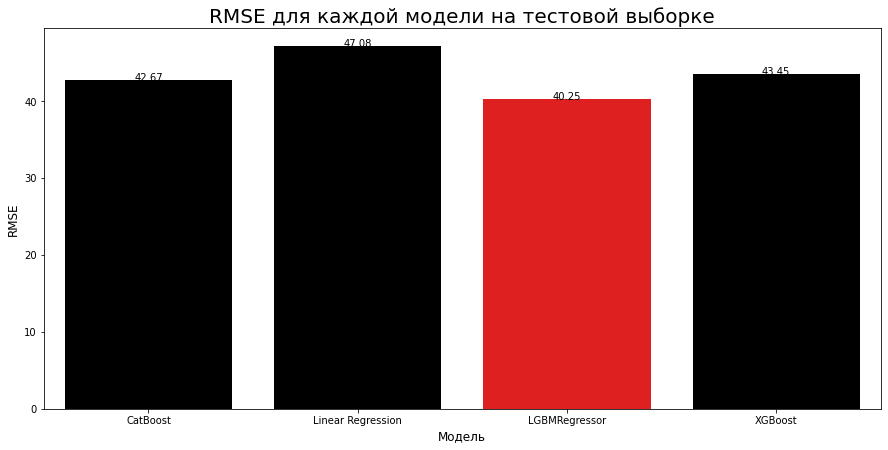

In [127]:
custom_palette = ['black', 'black', 'red', 'black', 'black']

plt.figure(figsize=(15, 7))

p = sns.barplot(x='model', y='testing_rmse', data=predictive_model_scores, palette=custom_palette)

plt.title('RMSE для каждой модели на тестовой выборке', fontsize=20)
plt.xlabel('Модель', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_rmse, s=round(row.testing_rmse, 2), color='black', ha='center');

#### Вывод
<br>
Значение метрики RMSE на тестовой выборке для всех моделей не превышает установленный в задании порог в 48. Однако следует отметить, что наилучшей моделью является LGBMRegressor с RMSE на тестовой выборке, равным 40.25.